# RATINGS: scRaping and AnalyzIng biTcoIN mininG poolS
### Progetto di Fine Corso A.A. 2023/24
### Carlo Tarabbo [654342]

## Analisi Generale dei dati della Blockchain
Per prima cosa vengono fatte delle analisi sul segmento iniziale di transazioni di Bitcoin contenuti nel DataSet
- L'andamento delle fee contenute nelle transazioni non Coinbase sono in relazione con la congestione della rete in un certo intervallo di tempo?
- Che tipi di script sono contenuti nel dataset e come e' cambiato il loro utilizzo nei primi 3 anni di vita di Bitcoin?

In [1]:
#per prima cosa importiamo le librerie che verranno usate per l'analisi.
import pandas as pd
import matplotlib.pyplot as plt

### Andamento delle fee rispetto alla congestione

In [2]:
# apertura e setup del dataframe delle transazioni, per ora mi interessano solo i txId che non sono coinbase e le loro fee
tdf = pd.read_csv("./datasets/transactions.csv", 
                  names=['timestamp', 'blockId', 'txId', 'isCoinbase','fee'] , 
                  dtype={'timestamp':'int32' , 'blockId':'int32', 'txId':'int32' , 'isCoinbase':'bool' , 'fee':'int64'})
tdf = tdf[tdf['isCoinbase'] == 0]
tdf.drop(['blockId', 'isCoinbase'], axis=1, inplace=True)
print(tdf)

#creo una lista delle transazioni valide per poter filtrare gli input e output 
valid_txid = tdf['txId'].tolist()

           timestamp      txId     fee
171       1231731025       171       0
183       1231740133       183       0
185       1231740736       185       0
187       1231742062       187       0
192       1231744600       192       0
...              ...       ...     ...
10572824  1356997957  10572822  100000
10572825  1356997957  10572823  100000
10572826  1356997957  10572824  100000
10572827  1356997957  10572825  100000
10572828  1356997957  10572826  100000

[10358266 rows x 3 columns]


In [3]:
# apertura ed elaborazione del dataframe di inputs, filtro con i txids validi
idf =  pd.read_csv("./datasets/inputs.csv", names=['txId','prevTxId','prevTxpos'], dtype={'txId':'int32','prevTxId':'int32','prevTxpos':'int32'})
idf.drop(['prevTxpos','prevTxId'], axis=1, inplace=True)
idf = idf[idf['txId'].isin(valid_txid)]

#faccio una count per avere quanti input ha ogni transazione e moltiplico per 40 byte per ottenere la size
idf = idf.value_counts().to_frame()
idf.rename(columns={'count' : 'tx_input_size'}, inplace=True)
#moltiplico la colonna della size : numero di input * 40 bytes
idf['tx_input_size'] *= 40
print(idf)

#faccio una merge sul dataframe delle transazioni per aggiungerci la size in bytes per ogni transazione
tdf = pd.merge(
  tdf ,
  idf['tx_input_size'] , 
  on='txId' ,
  how='left' ,
)


         tx_input_size
txId                  
7552999          52480
60952            38600
121669           36040
92402            33400
93005            32960
...                ...
4180697             40
4180696             40
4180695             40
4180694             40
5370299             40

[10358266 rows x 1 columns]


In [4]:
#apertura e filtro del DataSet di outputs con i txIds delle transazioni valide
odf = pd.read_csv("./datasets/outputs.csv", names=['txId', 'position', 'adressId', 'amount','scripttype'], dtype={'txId':'int32','position':'int32','adressId':'int64','amount':'int32','scripttype':'category'})
odf.drop(['position' , 'amount', 'adressId'], axis=1, inplace=True)
odf = odf[odf['txId'].isin(valid_txid)]
# print(odf)

## processo l'outputs dataframe
script_sizes = {'0': 0 , '1': 153, '2': 180, '3': 291}  # Coefficenti della size per i diversi scripttype

#creo una counts series e la coverto a dataframe 
counts = pd.DataFrame(odf.value_counts())

#1. creo un array dove salvare i diversi dataframe che ottengo con la groupby
#2. Ottengo un dataframe per tipo di scripttype contenente il txId della transazione in output e quanti output con quel determinato txId e scripttype sono presenti nel dataset outputs
#3. Definisco il peso per ogni txId che ha ogni tipo di script, moltiplicando ogni script per il peso che contribuisce per quella transazione
#4. Calcolo il risultato finale del peso
#5. Con una merge lo aggiungo al DataFrame delle transazioni


sizedf = pd.DataFrame()
sizedf[['timestamp','txId']] = tdf[['timestamp','txId']]

print(sizedf)



for script_type , new_df in counts.groupby(level=1):
    # output_df.append(new_df['count'])
    new_df.set_index(new_df.index.get_level_values(0), inplace=True)
    new_df.rename(columns={'count' : script_type}, inplace=True)
    sizedf = pd.merge(
        sizedf,
        new_df[script_type],
        on='txId',
        how='left',
    )

sizedf.fillna(0, inplace=True)
sizedf['tx_output_size'] = sizedf['1'] * (9 + 153) + sizedf['2'] * (9 + 180) + sizedf['3'] * (9 + 291)

print(sizedf)
tdf = pd.merge(
  tdf ,
  sizedf[['txId','tx_output_size']] , 
  on='txId' ,
  how='left' ,
)

print(tdf)

           timestamp      txId
0         1231731025       171
1         1231740133       183
2         1231740736       185
3         1231742062       187
4         1231744600       192
...              ...       ...
10358261  1356997957  10572822
10358262  1356997957  10572823
10358263  1356997957  10572824
10358264  1356997957  10572825
10358265  1356997957  10572826

[10358266 rows x 2 columns]


/var/folders/k5/hv224hb94mbd_04zpwlf07g80000gn/T/ipykernel_25327/3575020958.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for script_type , new_df in counts.groupby(level=1):


           timestamp      txId    1    2    0    3  tx_output_size
0         1231731025       171  2.0  0.0  0.0  0.0           324.0
1         1231740133       183  2.0  0.0  0.0  0.0           324.0
2         1231740736       185  2.0  0.0  0.0  0.0           324.0
3         1231742062       187  2.0  0.0  0.0  0.0           324.0
4         1231744600       192  1.0  0.0  0.0  0.0           162.0
...              ...       ...  ...  ...  ...  ...             ...
10358261  1356997957  10572822  0.0  2.0  0.0  0.0           378.0
10358262  1356997957  10572823  0.0  2.0  0.0  0.0           378.0
10358263  1356997957  10572824  0.0  2.0  0.0  0.0           378.0
10358264  1356997957  10572825  0.0  2.0  0.0  0.0           378.0
10358265  1356997957  10572826  0.0  3.0  0.0  0.0           567.0

[10358266 rows x 7 columns]
           timestamp      txId     fee  tx_input_size  tx_output_size
0         1231731025       171       0             40           324.0
1         1231740133       

In [5]:
# Salvo la tabella delle size prima di calcolare la congestione
tdf.to_csv('./transaction_sizes.csv', index=False)

#### Creazione della colonna congestione (per transazione)
La formula della congestione dell'impatto di una transazione e' la seguente: `size(transaction)= size(input)* n_inputs+ size (output)* n_outputs + size (script)`

-> Nella tabella `tdf` ora ho, per ogni `txId`, una colonna contenente la size degli input e una con la size degli output + size degli script per ogni output

In [6]:
#uso la funzione summ sulle due colonne per sommare riga per riga (axis=1)
tdf['congestione'] = tdf[['tx_input_size' , 'tx_output_size']].sum(axis=1)


In [7]:
# Salvo la tabella della congestione
tdf.to_csv('./analisi_congestione.csv' , index=False)

#### Dalla congestione delle singole transazioni all'analisi temporale del rapporto tra congestione e fees

Ora che abbiamo un DataSet che contiene tutti i dati di interesse per le diverse transazioni nei primi anni della Blockchain di Bitcoin, possiamo continuare con l'analisi temporale del rapporto tra Fees e Congestione

Per l'analisi verra' scelto un quanto di tempo (`qdt`) di una settimana per confrontare le fees rilasciate rispetto alla congestione.

La congestione verra' espressa in `KB`, le fees invece verranno lasciate nell'unita' di misura originale

L'approccio che verra' preso consiste in un resample settimanale del DataSet contenete i dati di interesse.

In [8]:
#apro sulla variabile tdf il dataset calcolato prima
tdf = pd.read_csv('./analisi_congestione.csv' , dtype={'timestamp':'int64' , 'txId':'int32' , 'fee':'int64' , 'congestione':'int32'})
tdf.drop(['tx_input_size' , 'tx_output_size'], axis=1 ,inplace=True)

In [9]:
# conversione del tempo da UNIX timestamp a data
tdf['timestamp'] = pd.to_datetime(tdf['timestamp'], unit='s')

#converto congestione da byte a KB
tdf['congestione'] = tdf['congestione'] / (1024)

In [10]:
#resample del dataset, settimanalmente prendo la somma delle congestioni delle transazioni e la media delle fee rilasciate
mean_tdf = pd.DataFrame()
mean_tdf['fee'] = tdf.resample('W-MON', on='timestamp')[['fee']].mean()
mean_tdf['congestione'] = tdf.resample('W-MON' , on='timestamp')['congestione'].sum()

#ottengo cosi' il timestamp come index e 'fee' e 'congestione' come colonne

print(mean_tdf)

                     fee    congestione
timestamp                              
2009-01-12  0.000000e+00       2.171875
2009-01-19  0.000000e+00       4.818359
2009-01-26  0.000000e+00       3.688477
2009-02-02  0.000000e+00       2.380859
2009-02-09  9.136364e+06       9.489258
...                  ...            ...
2012-12-03  1.149923e+05  109921.471680
2012-12-10  8.127036e+04  122512.072266
2012-12-17  8.468059e+04  136494.234375
2012-12-24  8.164706e+04  151118.530273
2012-12-31  8.045071e+04  140551.110352

[208 rows x 2 columns]


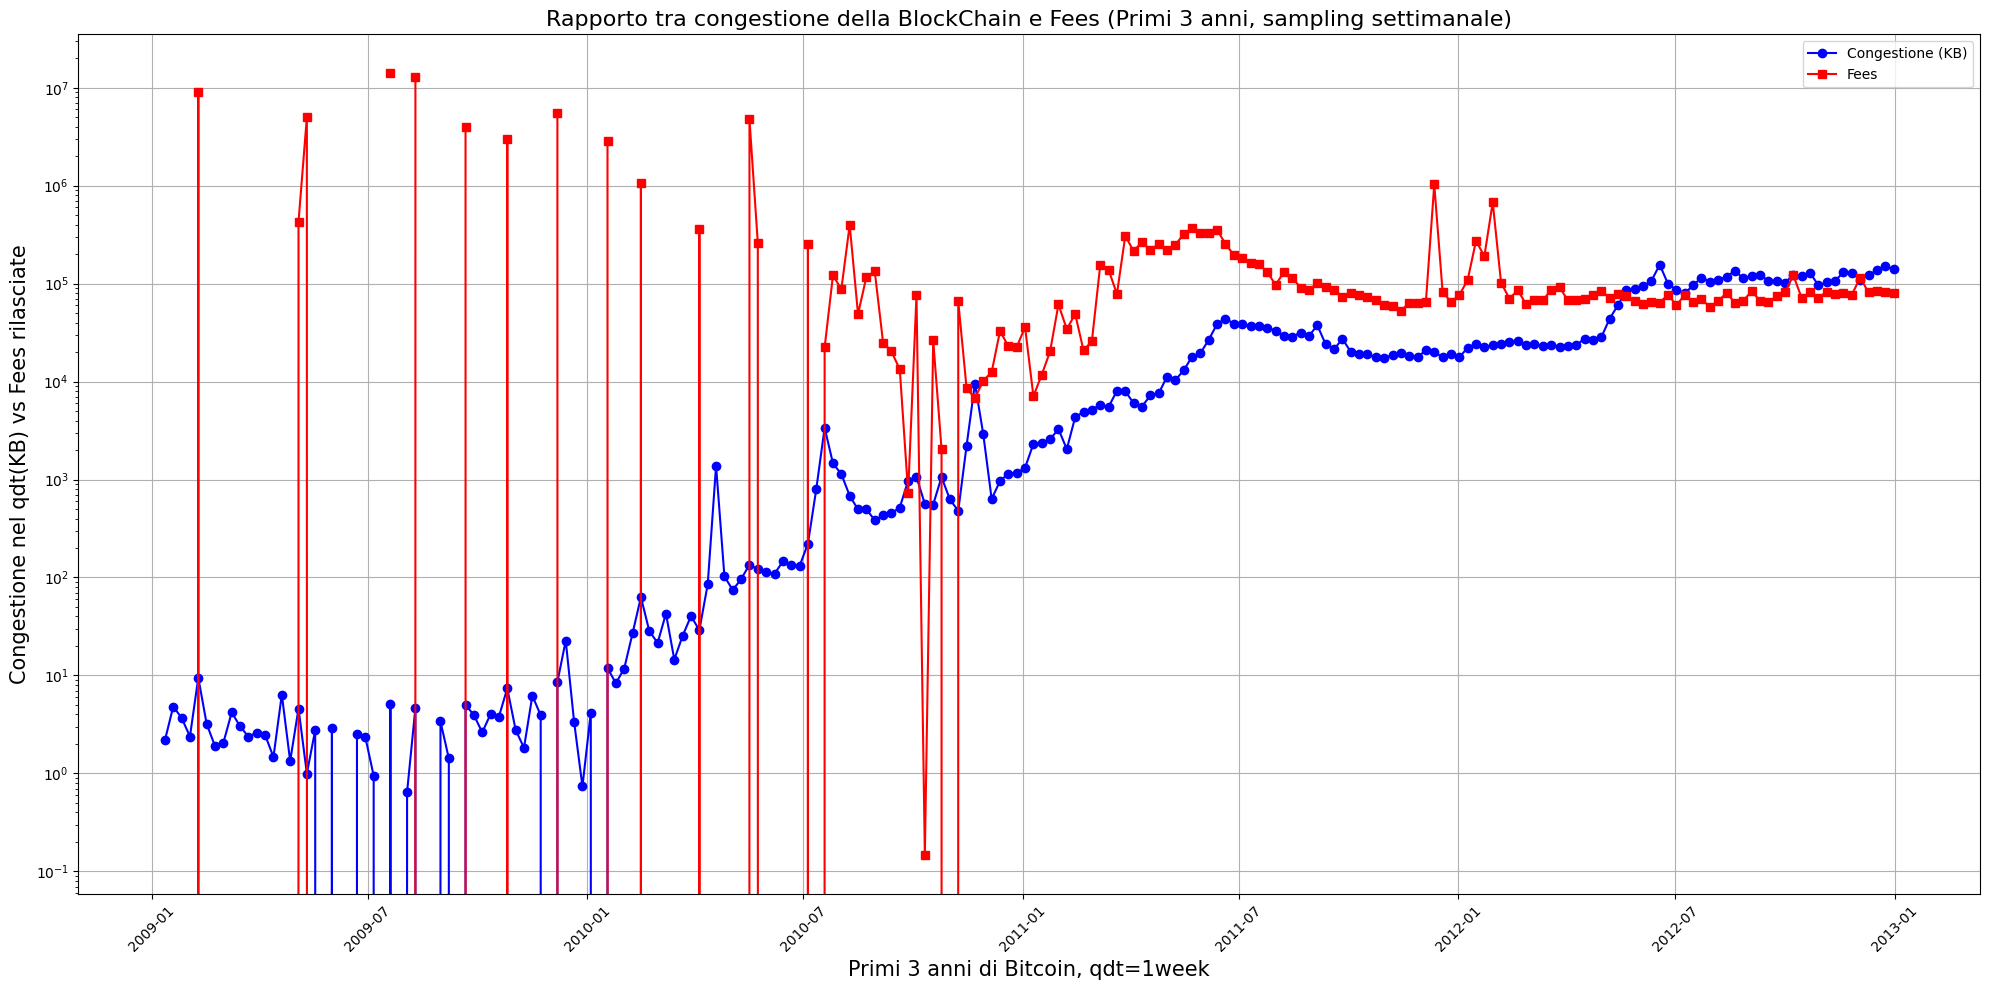

In [11]:
#creazione del grafico di comparazione con pyplot
plt.rcParams['agg.path.chunksize'] = 1000  # Aumento la chunksize per evitare problemi con plot con molti dati

plt.figure(figsize=(20, 10))  # Dimensione della figura

# Plot congestione 
plt.plot(mean_tdf.index, mean_tdf['congestione'], label='Congestione (KB)', marker='o', color='b')

# Plot fee
plt.plot(mean_tdf.index, mean_tdf['fee'], label='Fees', marker='s', color='r')

# Imposto la scala logaritmica per l'asse delle y per rendere le differenze piu' evidenti e comprensibili
plt.yscale('log')  # Set y-axis to logarithmic scale for fee

# Imposto le label varie
plt.xlabel("Primi 3 anni di Bitcoin, qdt=1week", fontsize=15)
plt.ylabel("Congestione nel qdt(KB) vs Fees rilasciate", fontsize=15)
plt.title("Rapporto tra congestione della BlockChain e Fees (Primi 3 anni, sampling settimanale)", fontsize=16) #Titolo
plt.xticks(rotation=45)  # Ruoto le label dell'asse delle x per renderlo piu' semplice da leggere
plt.grid(True)  
plt.legend()  

plt.tight_layout()  # Aggiusto lo spacing tra gli elementi
plt.show()

Dal grafico si puo' vedere che sembra esserci una correlazione tra la congestione della blockchain e la quantita' di fees rilasciate ai miner. Si nota bene soprattutto nel periodo tra November 2010 e Aprile 2012. 

Questa relazione pero' non e' l'unica che va a influire sul valore delle fees rilasciate durante il mining: altre variabili che, per esempio, possono influire sono il prezzo della moneta e la disponibilita' e potenza dell'hardware per minare.

### Analisi del tipo di script utilizzati dalle transazioni

In [16]:
#riapro il dataset delle transazioni non filtrato
tdf = pd.read_csv("./datasets/transactions.csv", 
                  names=['timestamp', 'blockId', 'txId', 'isCoinbase','fee'] , 
                  dtype={'timestamp':'int32' , 'blockId':'int32', 'txId':'int32' , 'isCoinbase':'bool' , 'fee':'int64'})

#apertura del DataSet di outputs con i txIds, questa volta senza filtrare quelli "validi"
odf = pd.read_csv("./datasets/outputs.csv", names=['txId', 'position', 'adressId', 'amount','scripttype'], dtype={'txId':'int32','position':'int32','adressId':'int64','amount':'int32','scripttype':'category'})
odf.drop(['position' , 'amount', 'adressId'], axis=1, inplace=True)
# print(odf)

#creo una counts series e la coverto a dataframe 
counts = pd.DataFrame(odf.value_counts())

In [17]:
#creo un dataframe typedf che contiene i timestamps e i txIds del dataframe delle transazioni
typedf = pd.DataFrame()
typedf[['timestamp','txId']] = tdf[['timestamp','txId']]


#come prima, aggiungo al dataframe typedf le volte che ogni tipo di script e' stato utilizzato da una transazione

for script_type , new_df in counts.groupby(level=1):
    # output_df.append(new_df['count'])
    new_df.set_index(new_df.index.get_level_values(0), inplace=True)
    new_df.rename(columns={'count' : script_type}, inplace=True)
    typedf = pd.merge(
        typedf,
        new_df[script_type],
        on='txId',
        how='left',
    )

#riempio i NaN creati dalla merge con 0 per poterci creare il grafico 
typedf.fillna(0, inplace=True)
# print(typedf)

/var/folders/k5/hv224hb94mbd_04zpwlf07g80000gn/T/ipykernel_25327/1797121616.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for script_type , new_df in counts.groupby(level=1):


In [18]:
#formatto i timestamp come data
typedf['timestamp'] = pd.to_datetime(typedf['timestamp'], unit='s')

#creo il dataframe con i dati settimanali
weekly_typedf = pd.DataFrame()

#definisco i valori degli utilizzi settimanali dei diversi tipi di script 
weekly_typedf['0'] = typedf.resample('W-MON' , on='timestamp')['0'].sum()
weekly_typedf['1'] = typedf.resample('W-MON' , on='timestamp')['1'].sum()
weekly_typedf['2'] = typedf.resample('W-MON' , on='timestamp')['2'].sum()
weekly_typedf['3'] = typedf.resample('W-MON' , on='timestamp')['3'].sum()

print(weekly_typedf)

                0       1         2    3
timestamp                               
2009-01-05    0.0     1.0       0.0  0.0
2009-01-12    0.0   274.0       0.0  0.0
2009-01-19    0.0   835.0       2.0  0.0
2009-01-26    0.0   884.0       3.0  0.0
2009-02-02    0.0   827.0       4.0  0.0
...           ...     ...       ...  ...
2012-12-03  128.0  8289.0  496283.0  0.0
2012-12-10  102.0  5557.0  553544.0  4.0
2012-12-17   80.0  5235.0  620328.0  2.0
2012-12-24  143.0  4890.0  684828.0  5.0
2012-12-31  141.0  5532.0  639216.0  0.0

[209 rows x 4 columns]


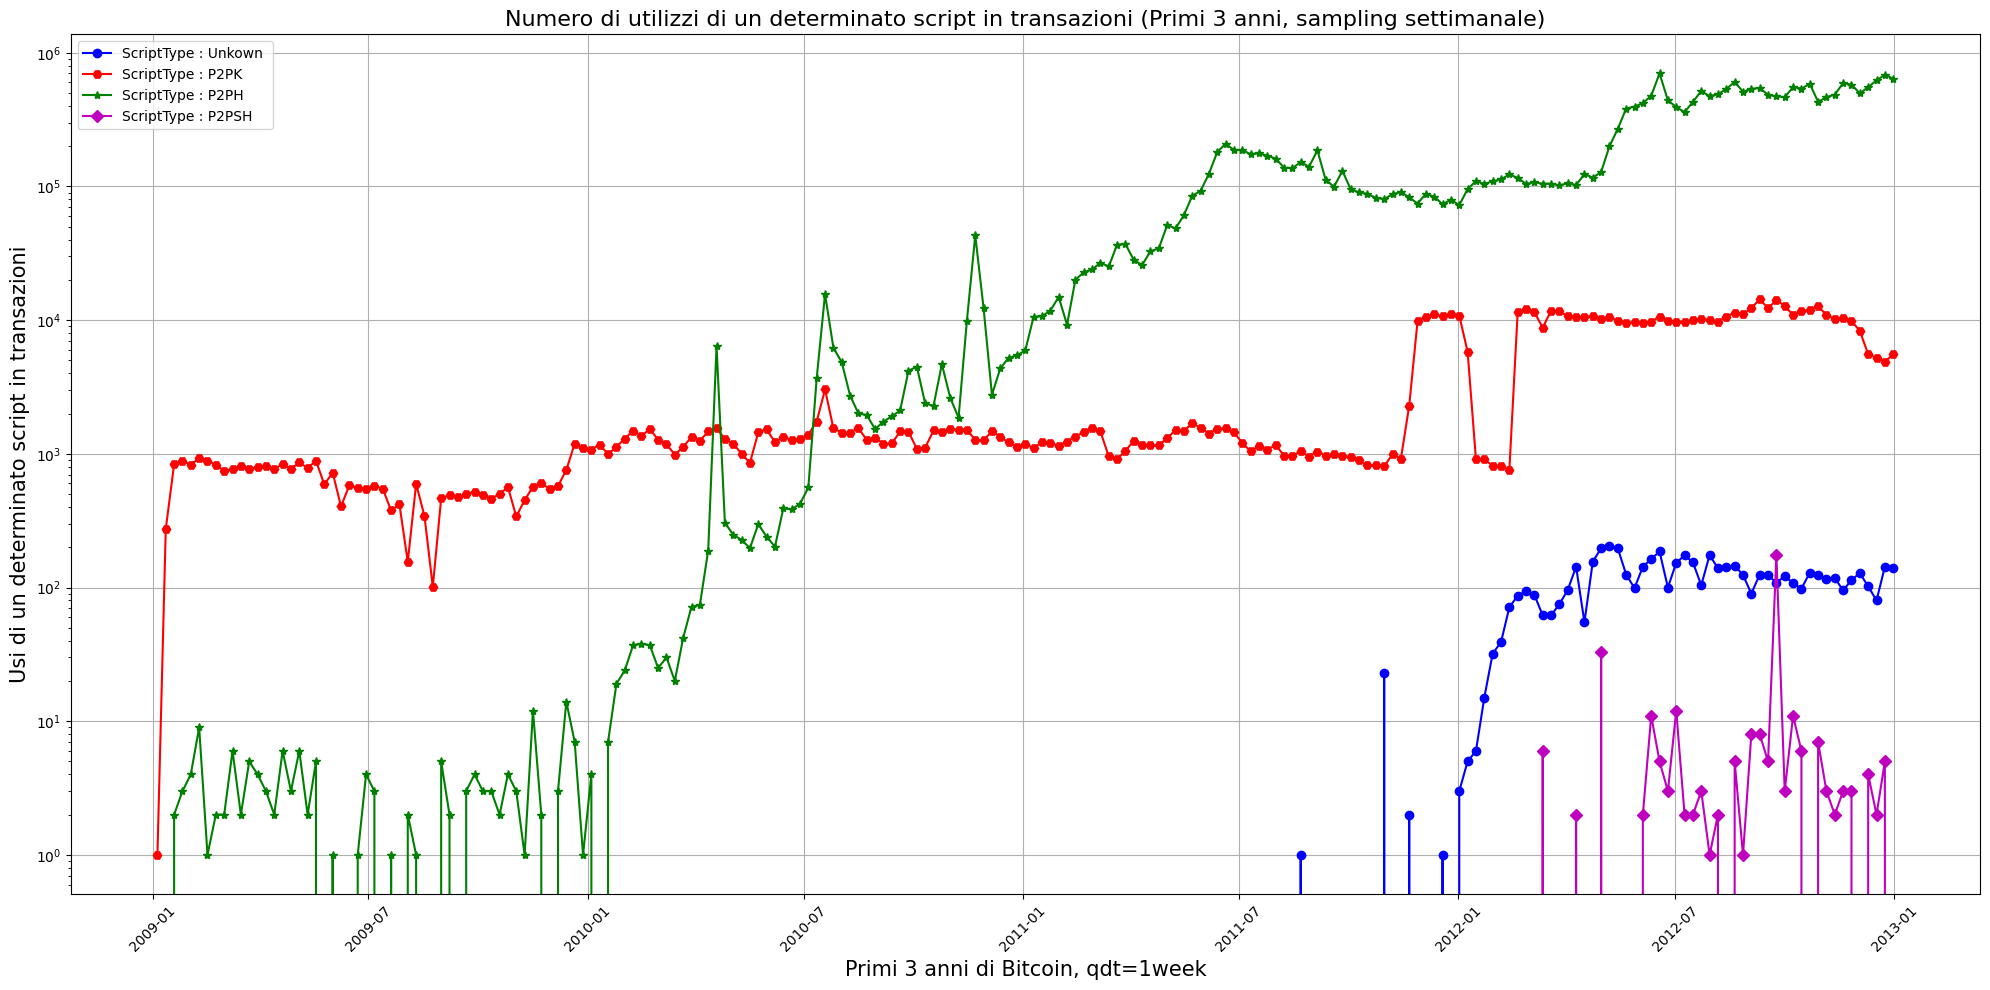

In [19]:
#creazione del grafico di comparazione con pyplot
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 1000  # Aumento la chunksize per evitare problemi con plot con molti dati

plt.figure(figsize=(20, 10))  # Dimensione della figura

# Plot 0 
plt.plot(weekly_typedf.index, weekly_typedf['0'], label='ScriptType : Unkown ', marker='o', color='b')
# Plot 1 
plt.plot(weekly_typedf.index, weekly_typedf['1'], label='ScriptType : P2PK ', marker='H', color='r')
# Plot 2
plt.plot(weekly_typedf.index, weekly_typedf['2'], label='ScriptType : P2PH ', marker='*', color='g')
# Plot 3
plt.plot(weekly_typedf.index, weekly_typedf['3'], label='ScriptType : P2PSH ', marker='D', color='m')



# Imposto la scala logaritmica per l'asse delle y per rendere le differenze piu' evidenti e comprensibili
plt.yscale('log')  # Set y-axis to logarithmic scale for fee

# Imposto le label varie
plt.xlabel("Primi 3 anni di Bitcoin, qdt=1week", fontsize=15)
plt.ylabel("Usi di un determinato script in transazioni", fontsize=15)
plt.title("Numero di utilizzi di un determinato script in transazioni (Primi 3 anni, sampling settimanale)", fontsize=16) #Titolo
plt.xticks(rotation=45)  # Ruoto le label dell'asse delle x per renderlo piu' semplice da leggere
plt.grid(True)  
plt.legend()  

plt.tight_layout()  # Aggiusto lo spacing tra gli elementi
plt.show()